In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAXResults



In [3]:
model_file_path = '/content/forecast_model.pkl'
data_file = '/content/smart_home_energy_consumption_large.csv'

In [4]:
df_smart_home = pd.read_csv(data_file)
result = SARIMAXResults.load(model_file_path)

In [5]:
df_smart_home['Datetime'] = pd.to_datetime(df_smart_home['Date'] +
                                            ' ' +
                                            df_smart_home['Time'])
df_smart_home['Date'] = pd.to_datetime(df_smart_home['Date'])
df_smart_home['Hour'] = df_smart_home['Datetime'].dt.hour
df_smart_home['Day_of_week'] = df_smart_home['Datetime'].dt.day_name()
df_smart_home['Month'] = df_smart_home['Datetime'].dt.month

df_smart_home.head()

,Home ID,Appliance Type,Energy Consumption (kWh),Time,Date,Outdoor Temperature (°C),Season,Household Size,Datetime,Hour,Day_of_week,Month
0,94,Fridge,0.20,21:12,2023-12-02,-1.0,Fall,2,2023-12-02 21:12:00,21,Saturday,12
1,435,Oven,0.23,20:11,2023-08-06,31.1,Summer,5,2023-08-06 20:11:00,20,Sunday,8
2,466,Dishwasher,0.32,06:39,2023-11-21,21.3,Fall,3,2023-11-21 06:39:00,6,Tuesday,11
3,496,Heater,3.92,21:56,2023-01-21,-4.2,Winter,1,2023-01-21 21:56:00,21,Saturday,1
4,137,Microwave,0.44,04:31,2023-08-26,34.5,Summer,5,2023-08-26 04:31:00,4,Saturday,8


In [6]:
aggregations = {
    'Energy Consumption (kWh)': 'sum',
    'Day_of_week': 'first',
    'Month': 'first',
}

df_daily_summary = df_smart_home.groupby('Date').agg(aggregations).reset_index()

df_daily_summary = df_daily_summary.rename(columns={
    'Energy Consumption (kWh)': 'total_daily_energy_kWh',
})

display(df_daily_summary)

,Date,total_daily_energy_kWh,Day_of_week,Month
0,2023-01-01,466.40,Sunday,1
1,2023-01-02,401.01,Monday,1
2,2023-01-03,375.64,Tuesday,1
3,2023-01-04,454.80,Wednesday,1
4,2023-01-05,460.98,Thursday,1
...,...,...,...,...
361,2023-12-28,378.84,Thursday,12
362,2023-12-29,425.19,Friday,12
363,2023-12-30,373.69,Saturday,12
364,2023-12-31,390.34,Sunday,12


In [7]:
def predict_budget_outcome(budget, daily_consumption_df, today_str, sarimax_result):
    today = pd.to_datetime(today_str)
    df = daily_consumption_df.copy().set_index('Date')
    start_of_month = today.to_period('M').start_time
    total_days_in_month = today.days_in_month
    current_month_data = df.loc[start_of_month:today]
    consumption_so_far = current_month_data['total_daily_energy_kWh'].sum()
    days_passed_in_month = len(current_month_data)

    print(f"--- This Month's Data (up to {today.strftime('%Y-%m-%d')}) ---")
    print(f"Energy Consumption so far: {consumption_so_far:.2f} kWh")
    print(f"Days passed: {days_passed_in_month} days")
    print("--------------------------------------")

    days_to_forecast = total_days_in_month - days_passed_in_month

    if days_to_forecast <= 0:
        print("Month is already over, no forecast needed.")
        monthly_cumulative_usage = current_month_data['total_daily_energy_kWh'].cumsum()
        return monthly_cumulative_usage, budget

    future_forecast = sarimax_result.get_forecast(steps=days_to_forecast).predicted_mean
    last_historical_date = current_month_data.index.max()
    forecast_dates = pd.date_range(start=last_historical_date + pd.Timedelta(days=1), periods=days_to_forecast)
    future_forecast.index = forecast_dates

    historical_daily = current_month_data['total_daily_energy_kWh']
    full_month_daily_usage = pd.concat([historical_daily, future_forecast])
    monthly_cumulative_usage = full_month_daily_usage.cumsum()
    estimate_total_usage = monthly_cumulative_usage.iloc[-1]

    print(f"Predicted total usage for this month: {estimate_total_usage:.2f} kWh")
    print(f"Your Budget: {budget:.2f} kWh")

    if estimate_total_usage > budget:
        print('\nbad j*b\n\n!')
    else:
        print('\ngood j*b!\n\n')

    return monthly_cumulative_usage, budget



In [8]:
user_budget = 1500
today_string = '2023-08-15'
cumulative_usage_data, budget_limit = predict_budget_outcome(user_budget, df_daily_summary, today_string, result)

print("contoh buat ngeplot")
if cumulative_usage_data is not None:
    for date, cumulative_kwh in cumulative_usage_data.items():
        print(f"{date.strftime('%Y-%m-%d')}: {cumulative_kwh:.2f} kWh")

--- This Month's Data (up to 2023-08-15) ---
Energy Consumption so far: 6191.50 kWh
Days passed: 15 days
--------------------------------------
Predicted total usage for this month: 12670.93 kWh
Your Budget: 1500.00 kWh

bad j*b

!
contoh buat ngeplot
2023-08-01: 421.00 kWh
2023-08-02: 808.40 kWh
2023-08-03: 1210.61 kWh
2023-08-04: 1635.83 kWh
2023-08-05: 2067.79 kWh
2023-08-06: 2490.17 kWh
2023-08-07: 2901.80 kWh
2023-08-08: 3348.48 kWh
2023-08-09: 3732.78 kWh
2023-08-10: 4118.94 kWh
2023-08-11: 4562.55 kWh
2023-08-12: 4925.43 kWh
2023-08-13: 5315.05 kWh
2023-08-14: 5775.80 kWh
2023-08-15: 6191.50 kWh
2023-08-16: 6599.25 kWh
2023-08-17: 7006.85 kWh
2023-08-18: 7408.82 kWh
2023-08-19: 7809.01 kWh
2023-08-20: 8215.54 kWh
2023-08-21: 8623.25 kWh
2023-08-22: 9024.04 kWh
2023-08-23: 9431.20 kWh
2023-08-24: 9839.25 kWh
2023-08-25: 10241.31 kWh
2023-08-26: 10641.01 kWh
2023-08-27: 11047.74 kWh
2023-08-28: 11455.48 kWh
2023-08-29: 11856.10 kWh
2023-08-30: 12263.07 kWh
2023-08-31: 12670.93 kWh

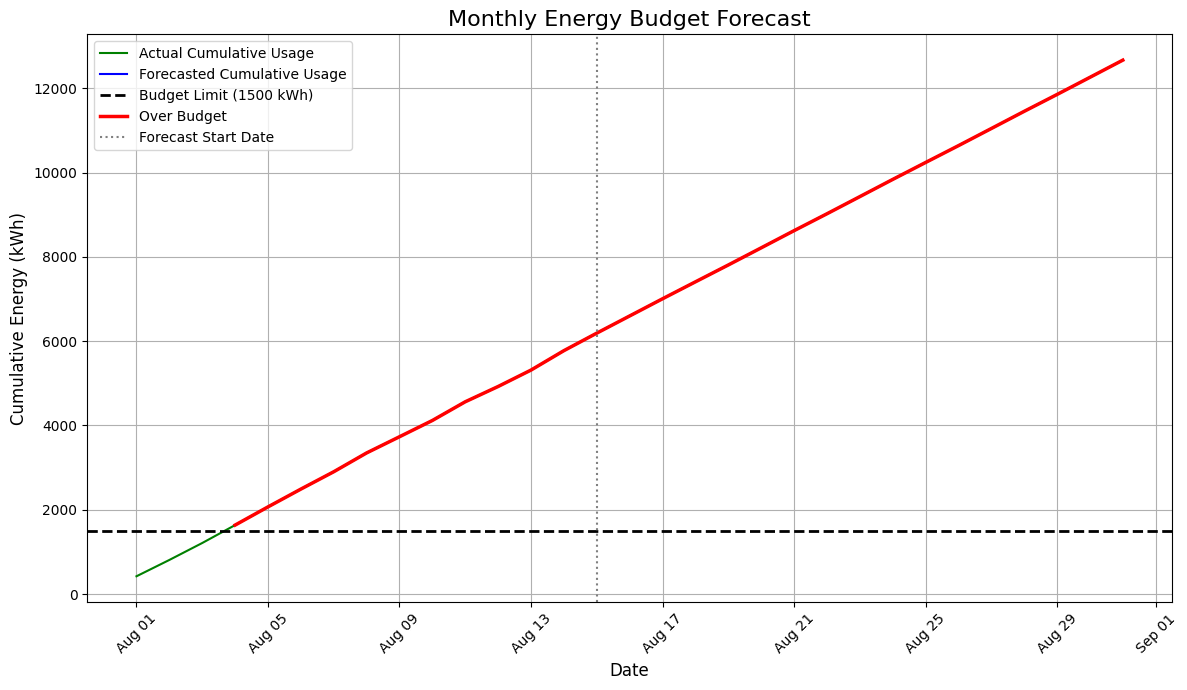

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

if cumulative_usage_data is not None:
    today_date = pd.to_datetime(today_string)
    actual_data = cumulative_usage_data[cumulative_usage_data.index <= today_date]
    forecast_data = cumulative_usage_data[cumulative_usage_data.index >= today_date]

    fig, ax = plt.subplots(figsize=(12, 7))


    ax.plot(actual_data.index, actual_data, linestyle='-', color='g', label='Actual Cumulative Usage')
    ax.plot(forecast_data.index, forecast_data, linestyle='-', color='b', label='Forecasted Cumulative Usage')


    ax.axhline(y=budget_limit, color='k', linestyle='--', linewidth=2, label=f'Budget Limit ({budget_limit} kWh)')


    over_budget_data = cumulative_usage_data[cumulative_usage_data > budget_limit]
    if not over_budget_data.empty:
        ax.plot(over_budget_data.index, over_budget_data, color='r', linewidth=2.5, label='Over Budget')

    ax.axvline(x=today_date, color='grey', linestyle=':', linewidth=1.5, label='Forecast Start Date')


    ax.set_title('Monthly Energy Budget Forecast', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Energy (kWh)', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig('energy_budget_forecast_styled.png')